In [1]:
import numpy as np
from scipy.sparse import csr_array, kron

## Funciones varias

In [28]:
def Puerta(name):
    dic = {"H": 1/np.sqrt(2)*np.matrix([[1,1],[1,-1]],dtype=np.float128),
           "Z": np.matrix([[1,0],[0,-1]],dtype=np.float128),
           "X": np.matrix([[0,1],[1,0]],dtype=np.float128),
           "Y": np.matrix([[0,i],[-i,0]],dtype=np.float128),
           "CX": np.matrix([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]],dtype=np.float128),
           "swap": np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]],dtype=np.float128)}
    
    if name == "H":
        return 1/np.sqrt(2)*np.array([[1,1],[1,-1]],dtype=np.float128)
    elif name == "swap":
        return np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    elif name == "cx":
        return np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
    
    
    raise ValueError("Puerta no definida")

In [3]:
def swaps(distancia):
    qubits = (0,distancia)
    num_qubits = qubits[1] - qubits[0] + 1
    swap = np.eye(2**num_qubits)
    mask1 = 1 << qubits[0]
    #anti_mask = ((1 << num_qubits) - 1) ^ mask1
    mask2 = 1 << qubits[1]

    for i in range(2**num_qubits):
        if (i & mask1) and ((i & mask2) == 0):
            swap[i,i] = 0
            swap[i-mask1+mask2,i-mask1+mask2] = 0
            swap[i,i-mask1+mask2] = 1
            swap[i-mask1+mask2,i] = 1

    return swap

In [109]:
def rep_canonica(state):
    for i in range(state.size):
        if state[i] != 0:
            arg = np.angle(state[i])
            canonica = np.exp(-arg*1j)*state
            canonica[i] = canonica[i].real
            return canonica

In [133]:
def coord_Bloch(state):
    if state.size%2 != 0:
        raise ValueError("Vector de estado no válido")
    
    canonica = rep_canonica(state=state)

    phi = np.angle(canonica[1])

    theta = 2*np.arctan2(np.absolute(canonica[1]),np.absolute(canonica[0]))
    
    return [theta, phi]

In [134]:
coord_Bloch(np.array([np.sqrt(2)/2,np.sqrt(2)/2],dtype=np.complex256))

[1.5707963267948966193, 0.0]

In [135]:
coord_Bloch(np.array([0,1],dtype=np.complex256))

[3.1415926535897932385, 0.0]

In [136]:
coord_Bloch(1j*np.array([0,1],dtype=np.complex256))

[3.1415926535897932385, 0.0]

In [137]:
coord_Bloch(np.array([-0.38268343, 0.92387953],dtype=np.complex256))

[2.3561944926404053509, 3.1415926535897932385]

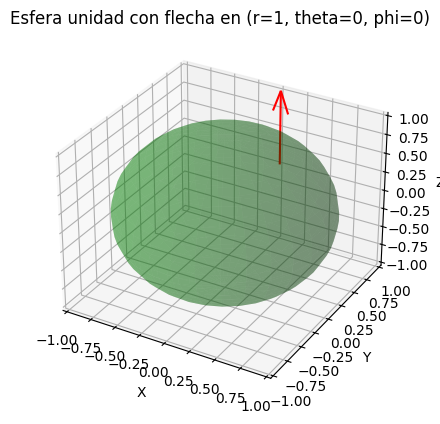

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creamos la malla de puntos en la esfera
phi = np.linspace(0, np.pi, 30)
theta = np.linspace(0, 2 * np.pi, 30)
phi, theta = np.meshgrid(phi, theta)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Graficamos la esfera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='Green', alpha=0.3)

# Coordenadas de la flecha
r = 1
theta = 0
phi = 0
x_arrow = r * np.sin(phi) * np.cos(theta)
y_arrow = r * np.sin(phi) * np.sin(theta)
z_arrow = r * np.cos(phi)

# Graficamos la flecha
ax.quiver(0, 0, 0, x_arrow, y_arrow, z_arrow, color='Red')

# Configuraciones adicionales
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Esfera unidad con flecha en (r=1, theta=0, phi=0)')

ax.grid = False

plt.show()

## Clase QRegistry

In [6]:
class QRegistry:
    def __init__(self,nqubits):
        self.nqubits = nqubits
        self.estado = np.append(np.array([1],dtype=complex),np.array([0 for _ in range(2**self.nqubits - 1)],dtype=complex)).reshape(-1,1)

    def ket(self):
        return self.estado
    
    def bra(self):
        return np.conjugate(np.transpose(self.estado))
    
    def M_densidad(self):
        return np.dot(self.ket(),self.bra())
    
    def aplicar_puerta(self, puerta, qubit):
        num_q_Puerta = int(np.log2(puerta.shape[0]))

        puerta = csr_array(puerta)

        if qubit[0] < 0 or len(qubit) > self.nqubits:
            raise ValueError("Qubit imposible")
        
        elif num_q_Puerta > self.nqubits:
            raise ValueError("La puerta no cabe")
        
        cambios = None

        if len(qubit) > 1:
            posiciones = qubit + [j for j in range(self.nqubits) if j not in qubit]
            cambios = np.argsort(posiciones)
            # print(cambios, posiciones)

            for id in range(len(qubit)):
                target_id = np.where(cambios == id)[0][0]
                print(f"SWAP({id},{target_id})")
                if id != target_id:
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])

        operacion = kron(kron(csr_array(np.eye(2**(self.nqubits - qubit[0] - num_q_Puerta))),puerta),csr_array(np.eye(2**qubit[0])))

        self.estado = operacion @ self.ket()

        print(cambios)

        if cambios is not None:
            for id in range(len(qubit)):
                target_id = np.where(cambios == id)[0][0]
                print(f"DESSWAP({id},{target_id})")
                if id != target_id:
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])

        return self.estado
    
    def medir(self, qubit):
        if qubit < 0 or qubit >= self.nqubits:
            raise ValueError("Qubit imposible")
        
        lista = [j for j in range(2**self.nqubits) if j//2**(qubit)%2]
        # print(lista)
        r = np.random.rand()
        p = sum(np.absolute(self.estado[i,0])**2 for i in lista)

        if r < p:
            #print("Mide 1")
            listadg = [j for j in range(2**self.nqubits) if j//2**(qubit)%2 == 0]
            for i in listadg:
                self.estado[i,0] = 0
            self.estado = self.estado/np.sqrt(p)
        else:
            #print("Mide 0")
            for i in lista:
                self.estado[i,0] = 0
            self.estado = self.estado/np.sqrt(1-p)

        return int(r < p)


In [7]:
registro = QRegistry(4)
registro.aplicar_puerta(Puerta("H"),qubit=[0])
# registro.aplicar_puertaM(swaps(1),qubit=[0])
registro.aplicar_puerta(Puerta("cx"),qubit=[0,2])

None
SWAP(0,0)
SWAP(1,2)
None
[0 2 1 3]
DESSWAP(0,0)
DESSWAP(1,2)
None


array([[0.70710678+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.70710678+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]], dtype=complex256)

## Ejemplos de uso

In [8]:
cx = Puerta("cx")
H = Puerta("H")

par_epr = QRegistry(2)
par_epr.aplicar_puerta(H,[0])
# display(par_epr.ket())

par_epr.aplicar_puerta(cx,[0,1])

display(par_epr.ket())

print(par_epr.medir(0))

print(par_epr.medir(1))

None
SWAP(0,0)
SWAP(1,1)
[0 1]
DESSWAP(0,0)
DESSWAP(1,1)


array([[0.70710678+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.70710678+0.j]], dtype=complex256)

0
0


In [9]:
registro = QRegistry(3)
registro.aplicar_puerta(np.kron(Puerta("H"),Puerta("H")),[1])
registro.ket()

None


array([[0.5+0.j],
       [0. +0.j],
       [0.5+0.j],
       [0. +0.j],
       [0.5+0.j],
       [0. +0.j],
       [0.5+0.j],
       [0. +0.j]], dtype=complex256)

In [10]:
registro = QRegistry(3)
hadamard = 1/np.sqrt(2)*np.array([[1,1],[1,-1]],dtype=np.float128)
registro.aplicar_puerta(hadamard,[0])
registro.aplicar_puerta(hadamard,[1])
registro.aplicar_puerta(hadamard,[2])
registro.aplicar_puerta(hadamard,[0])
registro.aplicar_puerta(hadamard,[1])
registro.aplicar_puerta(hadamard,[2])

None
None
None
None
None
None


array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]], dtype=complex256)

In [11]:
registro = QRegistry(3)
registro.medir(1)

0

In [12]:
ket0 = QRegistry(2)
ket0.ket()

array([[1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [13]:
ket0.bra()

array([[1.-0.j, 0.-0.j, 0.-0.j, 0.-0.j]])

In [14]:
ket0.M_densidad()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [15]:
ket0.aplicar_puerta(hadamard,qubit=[1])

None


array([[0.70710678+0.j],
       [0.        +0.j],
       [0.70710678+0.j],
       [0.        +0.j]], dtype=complex256)

In [16]:
ket0.medir(1)

1

In [17]:
ket0.ket()

array([[0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j]], dtype=complex256)

In [18]:
registro = QRegistry(3)
registro.aplicar_puerta(hadamard,[0,1,2])
registro.ket()

SWAP(0,0)
SWAP(1,1)
SWAP(2,2)
[0 1 2]
DESSWAP(0,0)
DESSWAP(1,1)
DESSWAP(2,2)


array([[0.70710678+0.j],
       [0.70710678+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]], dtype=complex256)

# Coste temporal

In [19]:
'''
n = distancia
t(n) = 2 + 2 + 3 + 2^{2(n + 1)} + n + 1 + 1 + 3 + n + 2 + n + 1 + 
 + 2^{n+1}*(1 + 5 + {3 + 7 + 5 + 5, 0})

t(n) = 15 + 2^{2(n + 1)} + 3*n + 2^{n+1}*({26, 6})

O =  2^{2n}
w =  2^{2n}
theta = 2^{2n}
'''
def swaps(distancia):
    qubits = (0,distancia) # Coste 2 (asignacion + creacion)
    # n = distancia + 1
    num_qubits = qubits[1] - qubits[0] + 1 # Coste 2xO(1) + 3 (acceso a lista + operaciones + asignacion)
    swap = np.eye(2**num_qubits) # Coste 2^{2(distancia + 1)} + distancia + 1 + 1 (potencia y asignacion)
    mask1 = 1 << qubits[0] # Coste 1 (solo el desplazamiento) + 2 (asignacion + acceso)
    #anti_mask = ((1 << num_qubits) - 1) ^ mask1
    mask2 = 1 << qubits[1] # Coste distancia + 2

    for i in range(2**num_qubits): # Coste distancia + 1 + 1*iteracion
        if (i & mask1) and ((i & mask2) == 0): # Coste 5
            swap[i,i] = 0 # Coste 3
            swap[i-mask1+mask2,i-mask1+mask2] = 0 # Coste 7
            swap[i,i-mask1+mask2] = 1 # Coste 5
            swap[i-mask1+mask2,i] = 1 # Coste 5

    return swap

In [20]:
'''
n = num_qubits
t(n) = 4 + (1 + (n + 1) + (8 + qubit)*2^{n}) + θ(1) + (2 + (7 + 2*θ(1))*2^{n-1}) + 
     + (2 + {1 + (n + 1) + (8 + qubit)*2^{n}, 1} + (5)*2^{n-1} + θ(1) + 1 + 2^{n}) + 3 = 
     = 13 + 2*θ(1) + n + (9 + qubit)*2^{n} + (12 + 2*θ(1))*2^{n-1} + {(n + 1) + (8 + qubit)*2^{n} , 0}

t(n) = O(2^{n}) # En el peor de los casos qubit = n - 1 => O(n) = n*2^{n}
t(n) = w(2^{n})
t(n) = θ(2^{n})
'''

def medir(self, qubit):
        if qubit < 0 or qubit >= self.nqubits: # 4 (asumimos que nunca entra dentro)
            raise ValueError("Qubit imposible")
        
        # lista = [] # 1
        # for j in range(2**self.nqubits): # (n + 1) + 2*2^{n}
        #   if j//2**(qubit)%2: # 1 + qubit + 2 + 2
        #       lista.append(j) # 1
        lista = [j for j in range(2**self.nqubits) if j//2**(qubit)%2]
        # len(lista) = len(listadg) = 2^{n-1}
        r = np.random.rand()    # O(1)
                                # w(1)
                                # θ(1)

        # p = 0 # 2 (interpretar como la llamada a la función sum?)
        # for i in lista: # (1 + θ(1))*iteracion = (1 + θ(1))*2^{n-1}
        #   p = p + np.absolute(self.estado[i,0])**2 # asignacion + potencia + suma + abs + acceso = 1 + 2 + 1 + θ(1) + 2 
        p = sum(np.absolute(self.estado[i,0])**2 for i in lista)

        if r < p: # 2
            #print("Mide 1")
            # lista = [] # 1
            # for j in range(2**self.nqubits): # (n + 1) + 2*2^{n}
            #   if j//2**(qubit)%2 == 0: # 1 + qubit + 2 + 2 + 1
            #       lista.append(j) # 1
            listadg = [j for j in range(2**self.nqubits) if j//2**(qubit)%2 == 0]

            for i in listadg: # 2*2^{n-1}
                self.estado[i,0] = 0 # 3
            self.estado = self.estado/np.sqrt(p) # θ(1) + 1 + 2^{n}
        else: # 1
            #print("Mide 0")
            for i in lista: # 2*2^{n-1}
                self.estado[i,0] = 0 # 3
            self.estado = self.estado/np.sqrt(1-p) # θ(1) + 1 + 2^{n}

        return int(r < p) # 3

In [21]:
'''
n = self.nqubits
t(n) = 

t(n) = O()
t(n) = w()
t(n) = θ()
'''

def aplicar_puerta(self, puerta, qubit):
        num_q_Puerta = int(np.log2(puerta.shape[0])) # 1 + 1 + O(1)

        if qubit[0] < 0 or len(qubit) > self.nqubits: # 1 + 5 # No entramos
            raise ValueError("Qubit imposible")
        
        elif num_q_Puerta > self.nqubits: # 1 + 1 # No entramos
            raise ValueError("La puerta no cabe")
        
        cambios = None # 1

        if len(qubit) > 1: # 1 + 2
            
            # posiciones  = qubit           # 1
            # for j in range(n):            # 2*it = 2*n
            #   if j not in qubit:          # 4
            #       posiciones.append(j)    # 1
            posiciones = qubit + [j for j in range(self.nqubits) if j not in qubit]     # 1 + 7*n
            cambios = np.argsort(posiciones)                                            # O(nlogn)
            
            # ids = [posiciones[i] for i in cambios]
            # print(cambios, posiciones)

            for id in range(len(qubit)):                                        # 2*it = 2*len(qubit)
                target_id = np.where(cambios == id)[0,0]                        # 1 + 2 + O(where)
                # print(f"SWAP({id},{target_id})")                              
                if id != target_id:                                             # 2
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])       # ...

        # 3 + n - qubit[0] - num_q_Puerta + 2^{2*(n - qubit[0] - num_q_Puerta)}
        operacion = np.kron(np.kron(np.eye(2**(self.nqubits - qubit[0] - num_q_Puerta)),puerta),np.eye(2**qubit[0]))

        self.estado = np.dot(operacion,self.ket())

        print(cambios)

        if cambios is not None:
            for id in range(len(qubit)):
                target_id = np.where(cambios == id)[0][0]
                print(f"DESSWAP({id},{target_id})")
                if id != target_id:
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])

        return self.estado

# Coste espacial

In [22]:
'''
n = self.nqubits
Unidad = 32 bits
(Una variable que almacena un valor simple ocupa 1 espacio de memoria)

Memoria para calcular la medida (en el pico):

p(n) = 6 + 2^{n-1} + {2^{n-1}, 0} + 4*2^{n}

p(n) = O(2^{n})
p(n) = w(2^{n})
p(n) = θ(2^{n})

'''

def medir(self, qubit):
        # self -> 1
        # qubit -> 1
        if qubit < 0 or qubit >= self.nqubits:
            raise ValueError("Qubit imposible")
        
        # lista -> 2^{n-1}
        # j -> 1
        lista = [j for j in range(2**self.nqubits) if j//2**(qubit)%2]
        # j -> 0 (tras liberar memoria)
        # r -> 2 + coste(rand) = 2 + θ(1)
        r = np.random.rand()


        # p -> 1 + 2*2^{n-1} + 2 + θ(1)
        # p = sum([np.absolute(self.estado[i,0])**2 for i in lista])
        # p -> 1 + 2 + θ(1) (tras liberar memoria)
        # p -> 1 + 2 + θ(1)
        p = sum(np.absolute(self.estado[i,0])**2 for i in lista)

        if r < p:
            #print("Mide 1")
            del lista
            # lista -> 0 (tras liberar espacio)
            # lista -> 2^{n-1}
            lista = [j for j in range(2**self.nqubits) if j//2**(qubit)%2 == 0]

            # i -> 1
            for i in lista:
                self.estado[i,0] = 0
            # i -> 0 (tras liberar memoria)
            # lista -> 0 (tras liberar espacio)
            del lista
            # division -> 4*2^{n}
            self.estado = self.estado/np.sqrt(p)
            # division -> 0 (tras liberar memoria)
        else:
            #print("Mide 0")
            # i -> 1
            for i in lista:
                self.estado[i,0] = 0
            # i -> 0 (tras liberar memoria)
            # lista -> 0 (tras liberar espacio)
            del lista
            # division -> 4*2^{n}
            self.estado = self.estado/np.sqrt(1-p)
            # division -> 0 (tras liberar memoria)

        return int(r < p)

In [23]:
'''
n = self.nqubits
V2 de medir
Unidad = 32 bits
(Una variable que almacena un valor simple ocupa 1 espacio de memoria)

Memoria para calcular la medida (en el pico):

p(n) = 6 + 2^{n-1} + {2^{n-1}, 0} + 4*2^{n}

p(n) = O(2^{n})
p(n) = w(2^{n})
p(n) = θ(2^{n})

'''

def medir(self, qubit):
        # self -> 1
        # qubit -> 1
        if qubit < 0 or qubit >= self.nqubits:
            raise ValueError("Qubit imposible")
        
        p = 0
        for id in range(1 << self.nqubits):
             if (id // (1 << qubit)) % 2:
                  p += np.absolute(self.elemento[id,0])**2

        r = np.random.rand()

        if r >= p:
            #print("Mide 0")
            p = 1 - p
        
        for id in range(1 << self.nqubits):
            if (id // (1 << qubit)) % 2:    # 1 en qubit
                if r <= p:  # Mide 1
                    self.estado[id] = self.estado[id]/np.sqrt(p)
                else:       # Mide 0
                    self.estado[id] = 0
            else:                           # 0 en qubit
                if r <= p:  # Mide 1
                    self.estado[id] = 0
                else:       # Mide 0
                    self.estado[id] = self.estado[id]/np.sqrt(p)

        return int(r < p)

In [24]:
'''
n = self.nqubits
Unidad = 32 bits
(Una variable que almacena un valor simple ocupa 1 espacio de memoria)

Memoria para calcular la medida (en el pico):

p(n) = ... 4*2^{n}

p(n) = O(2^{n})
p(n) = w(2^{n})
p(n) = θ(2^{n})

'''

def aplicar_puerta(self, puerta, qubit):
        num_q_Puerta = int(np.log2(puerta.shape[0]))        # 1

        if qubit[0] < 0 or len(qubit) > self.nqubits:
            raise ValueError("Qubit imposible")
        
        elif num_q_Puerta > self.nqubits:
            raise ValueError("La puerta no cabe")
        
        cambios = None                                      # 1

        if len(qubit) > 1:
            posiciones = qubit + [j for j in range(self.nqubits) if j not in qubit]
            cambios = np.argsort(posiciones)
            # print(cambios, posiciones)

            for id in range(len(qubit)):
                target_id = np.where(cambios == id)[0,0]
                print(f"SWAP({id},{target_id})")
                if id != target_id:
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])

        # 4*2^{n}
        operacion = np.kron(np.kron(np.eye(2**(self.nqubits - qubit[0] - num_q_Puerta)),puerta),np.eye(2**qubit[0]))

        self.estado = np.dot(operacion,self.ket())

        print(cambios)

        if cambios is not None:
            for id in range(len(qubit)):
                target_id = np.where(cambios == id)[0][0]
                # print(f"DESSWAP({id},{target_id})")
                if id != target_id:
                    self.aplicar_puerta(swaps(target_id - id),qubit=[id])

        return self.estado